In [1]:
# import libraries
import csv
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
    
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
sns.set(color_codes=True)

Importing data:

In [5]:
data_2018 = pd.read_csv('Data_2018_added_ZIP.csv')

In [3]:
data_2018_ZIP = pd.read_csv('Data_2018_groupedby_zip_and_sum.csv')

In [4]:
data_2018_PARK = pd.read_csv('Data_2018_groupedby_ParkingArea_and_sum.csv')

In this Notebook we will build various statsmodels to see which one is better at making prediction and which features play an important part in predicting parking availability. We will start with time units (day of the week, hour of the day) and then move to ZIP codes and Parking areas, since they cover different area sizes.

## 1 DATE & TIME

In [6]:
# check first 5 rows of dataframe
data_2018.head()

,OccupancyDateTime,PaidOccupancy,BlockfaceName,SideOfStreet,SourceElementKey,ParkingTimeLimitCategory,ParkingSpaceCount,PaidParkingArea,PaidParkingSubArea,PaidParkingRate,...,DayInMonth,Weekday,HourIn24HourClock,MinutesInHour,Longitude,Latitude,ParkingAvailability,AdjustedParkingAvailability,geometry,ZIP
0,04/20/2018 12:59:00 PM,2,MERCER ST BETWEEN PONTIUS AVE N AND YALE AVE N,S,11786,120.0,7,South Lake Union,South,NaN,...,20,Friday,12,59,-122.331086,47.624219,5,5,POINT (-122.33108562 47.6242189),98109
1,04/20/2018 12:59:00 PM,0,9TH AVE BETWEEN JEFFERSON ST AND JAMES ST,SW,8601,120.0,2,First Hill,NaN,NaN,...,20,Friday,12,59,-122.324500,47.605151,2,2,POINT (-122.32449968 47.60515148),98104
2,04/20/2018 12:59:00 PM,6,S MAIN ST BETWEEN 6TH AVE S AND MAYNARD AVE S,N,88773,120.0,12,Chinatown/ID,Edge,NaN,...,20,Friday,12,59,-122.325666,47.600108,6,6,POINT (-122.32566607 47.60010775),98104
3,04/20/2018 12:59:00 PM,0,COLUMBIA ST BETWEEN BOREN AVE AND MINOR AVE,SE,32558,120.0,8,First Hill,NaN,NaN,...,20,Friday,12,59,-122.323201,47.608111,8,8,POINT (-122.32320088 47.60811139),98104
4,04/20/2018 12:59:00 PM,8,NW 56TH ST BETWEEN 20TH AVE NW AND 22ND AVE NW,N,18621,240.0,11,Ballard,Edge,NaN,...,20,Friday,12,59,-122.383426,47.669513,3,3,POINT (-122.38342615 47.66951344),98107


In [7]:
# check additional information
data_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25671236 entries, 0 to 25671235
Data columns (total 31 columns):
OccupancyDateTime                                         object
PaidOccupancy                                             int64
BlockfaceName                                             object
SideOfStreet                                              object
SourceElementKey                                          int64
ParkingTimeLimitCategory                                  float64
ParkingSpaceCount                                         int64
PaidParkingArea                                           object
PaidParkingSubArea                                        object
PaidParkingRate                                           float64
ParkingCategory                                           object
Location                                                  object
2010CensusTracts                                          float64
SeattlePoliceDepartmentMicroCommunityPol

In [8]:
# check data summary statistics
data_2018.describe()

,PaidOccupancy,SourceElementKey,ParkingTimeLimitCategory,ParkingSpaceCount,PaidParkingRate,2010CensusTracts,SeattlePoliceDepartmentMicroCommunityPolicingPlanAreas,CityCouncilDistricts,SPDBeats,ZipCodes,Month,DayInMonth,HourIn24HourClock,MinutesInHour,Longitude,Latitude,ParkingAvailability,AdjustedParkingAvailability,ZIP
count,2.567124e+07,2.567124e+07,2.563116e+07,2.567124e+07,0.0,0.0,2.567124e+07,0.0,2.567124e+07,2.567124e+07,2.567124e+07,2.567124e+07,2.567124e+07,2.567124e+07,2.567124e+07,2.567124e+07,2.567124e+07,2.567124e+07,2.567124e+07
mean,3.478391e+00,4.578961e+04,1.844288e+02,7.598470e+00,NaN,NaN,2.978712e+01,NaN,1.710328e+01,1.876500e+04,3.627740e+00,1.657265e+01,1.336433e+01,2.949937e+01,-1.223356e+02,4.762003e+01,4.120079e+00,4.236369e+00,9.811100e+04
std,3.469280e+00,2.801176e+04,1.232965e+02,4.460174e+00,NaN,NaN,2.184320e+01,NaN,1.182637e+01,6.007007e+02,4.834071e-01,8.838107e+00,3.453594e+00,1.731879e+01,1.637640e-02,2.010952e-02,3.971910e+00,3.802064e+00,8.477266e+00
min,0.000000e+00,1.005000e+03,3.000000e+01,0.000000e+00,NaN,NaN,4.000000e+00,NaN,1.000000e+00,1.792300e+04,3.000000e+00,2.000000e+00,8.000000e+00,0.000000e+00,-1.223990e+02,4.755744e+01,-3.400000e+01,0.000000e+00,9.810100e+04
25%,1.000000e+00,2.083400e+04,1.200000e+02,5.000000e+00,NaN,NaN,8.000000e+00,NaN,9.000000e+00,1.837900e+04,3.000000e+00,9.000000e+00,1.000000e+01,1.400000e+01,-1.223449e+02,4.760962e+01,2.000000e+00,2.000000e+00,9.810400e+04
50%,3.000000e+00,4.625000e+04,1.200000e+02,7.000000e+00,NaN,NaN,1.900000e+01,NaN,1.200000e+01,1.839000e+04,4.000000e+00,1.700000e+01,1.300000e+01,2.900000e+01,-1.223337e+02,4.761517e+01,4.000000e+00,4.000000e+00,9.810900e+04
75%,5.000000e+00,6.948900e+04,2.400000e+02,9.000000e+00,NaN,NaN,5.600000e+01,NaN,2.400000e+01,1.957600e+04,4.000000e+00,2.400000e+01,1.600000e+01,4.500000e+01,-1.223244e+02,4.762197e+01,6.000000e+00,6.000000e+00,9.812100e+04
max,5.000000e+01,1.360410e+05,6.000000e+02,4.000000e+01,NaN,NaN,6.000000e+01,NaN,4.700000e+01,1.958400e+04,4.000000e+00,3.100000e+01,2.100000e+01,5.900000e+01,-1.222842e+02,4.768091e+01,4.000000e+01,4.000000e+01,9.816400e+04


In [6]:
# create smaller dataframe with selected columns
data_TIME = data_2018[['Weekday', 'HourIn24HourClock', 'PaidOccupancy', 'AdjustedParkingAvailability', 'ZIP']]

In [7]:
data_TIME.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25671236 entries, 0 to 25671235
Data columns (total 5 columns):
Weekday                        object
HourIn24HourClock              int64
PaidOccupancy                  int64
AdjustedParkingAvailability    int64
ZIP                            int64
dtypes: int64(4), object(1)
memory usage: 979.3+ MB


In [8]:
data_TIME.head()

,Weekday,HourIn24HourClock,PaidOccupancy,AdjustedParkingAvailability,ZIP
0,Friday,12,2,5,98109
1,Friday,12,0,2,98104
2,Friday,12,6,6,98104
3,Friday,12,0,8,98104
4,Friday,12,8,3,98107


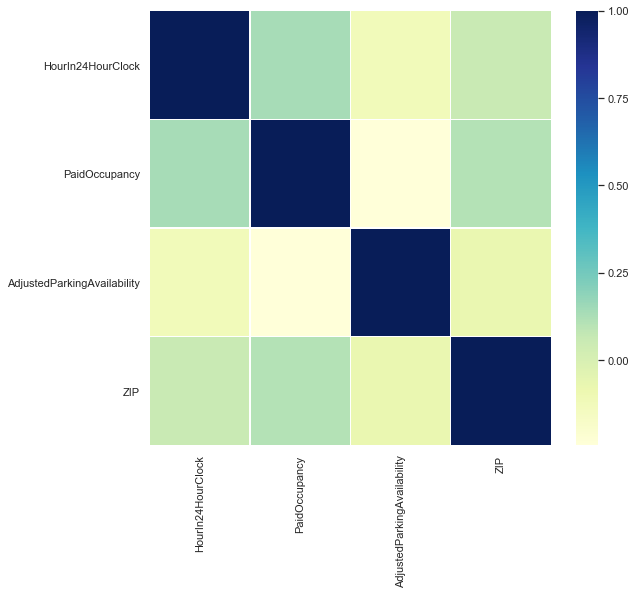

In [9]:
# correlation matrix for all variables
corrmat = data_TIME.corr()   
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

From the correlation matrix we can see there is low correlation between different variables.

### 1.1 STATSMODELS

In [10]:
# create a model and print the summary
m_TIME1 = ols('AdjustedParkingAvailability ~ C(Weekday)', data_TIME).fit()
print(m_TIME1.summary())

                                 OLS Regression Results                                
Dep. Variable:     AdjustedParkingAvailability   R-squared:                       0.001
Model:                                     OLS   Adj. R-squared:                  0.001
Method:                          Least Squares   F-statistic:                     6681.
Date:                         Sat, 28 Sep 2019   Prob (F-statistic):               0.00
Time:                                 20:05:57   Log-Likelihood:            -7.0694e+07
No. Observations:                     25671236   AIC:                         1.414e+08
Df Residuals:                         25671230   BIC:                         1.414e+08
Df Model:                                    5                                         
Covariance Type:                     nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [11]:
# create a model and print the summary
m_TIME2 = ols('AdjustedParkingAvailability ~ HourIn24HourClock', data_TIME).fit()
print(m_TIME2.summary())

                                 OLS Regression Results                                
Dep. Variable:     AdjustedParkingAvailability   R-squared:                       0.015
Model:                                     OLS   Adj. R-squared:                  0.015
Method:                          Least Squares   F-statistic:                 3.857e+05
Date:                         Sat, 28 Sep 2019   Prob (F-statistic):               0.00
Time:                                 20:07:34   Log-Likelihood:            -7.0520e+07
No. Observations:                     25671236   AIC:                         1.410e+08
Df Residuals:                         25671234   BIC:                         1.410e+08
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [12]:
# create a model and print the summary
m_TIME3 = ols('AdjustedParkingAvailability ~ C(Weekday) + HourIn24HourClock', data_TIME).fit()
print(m_TIME3.summary())

                                 OLS Regression Results                                
Dep. Variable:     AdjustedParkingAvailability   R-squared:                       0.016
Model:                                     OLS   Adj. R-squared:                  0.016
Method:                          Least Squares   F-statistic:                 6.992e+04
Date:                         Sat, 28 Sep 2019   Prob (F-statistic):               0.00
Time:                                 20:09:44   Log-Likelihood:            -7.0503e+07
No. Observations:                     25671236   AIC:                         1.410e+08
Df Residuals:                         25671229   BIC:                         1.410e+08
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

ANSWER:

In [15]:
# getting fitted values
m_TIME3_fitted = m_TIME3.fittedvalues.copy()

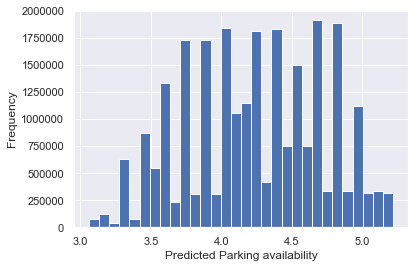

In [16]:
# frequency of predicted values
plt.hist(m_TIME3_fitted, bins=30)
plt.xlabel("Predicted Parking availability")
plt.ylabel("Frequency")
plt.show()

In [18]:
# calculate prediction errors
m_TIME3_residuals = data_TIME.AdjustedParkingAvailability - m_TIME3_fitted

KeyboardInterrupt: 

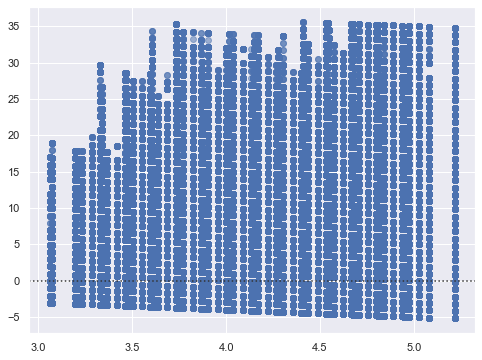

In [19]:
# create residual plot
plt.figure(figsize=(8,6))
_ = sns.residplot(m_TIME3_fitted, data_TIME.AdjustedParkingAvailability, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
_ = plt.title('Residuals vs Fitted')
_ = plt.xlabel('Fitted values')
_ = plt.ylabel('Residuals')
plt.show()

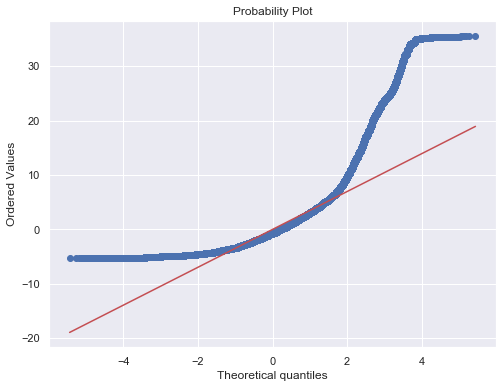

In [86]:
# construct a quantile plot of the residuals
fig, ax = plt.subplots(figsize=(8,6))
_, (__, ___, r) = stats.probplot(m_TIME3_residuals, plot=ax, fit=True)
plt.show()

By looking at this plot, we can say that predistion errors aren't normally distributed.

Since these models don't tell us much about parking availability in different locations, let's build a models based on ZIP codes and later parking areas to see which perfom better.

## 2 ZIP

In [18]:
# check the first 5 rows of the ZIP dataframe
data_2018_ZIP.head()

,ZIP,OccupancyDateTime,Weekday,Date,DayInMonth,HourIn24HourClock,MinutesInHour,PaidOccupancy,AdjustedParkingAvailability
0,98101,03/21/2018 01:00:00 PM,Wednesday,03/21/2018,21,13,0,523,783
1,98101,03/21/2018 01:01:00 PM,Wednesday,03/21/2018,21,13,1,526,781
2,98101,03/21/2018 01:02:00 PM,Wednesday,03/21/2018,21,13,2,522,784
3,98101,03/21/2018 01:03:00 PM,Wednesday,03/21/2018,21,13,3,517,792
4,98101,03/21/2018 01:04:00 PM,Wednesday,03/21/2018,21,13,4,520,790


In [9]:
# check additional information
data_2018_ZIP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298080 entries, 0 to 298079
Data columns (total 9 columns):
ZIP                            298080 non-null int64
OccupancyDateTime              298080 non-null object
Weekday                        298080 non-null object
Date                           298080 non-null object
DayInMonth                     298080 non-null int64
HourIn24HourClock              298080 non-null int64
MinutesInHour                  298080 non-null int64
PaidOccupancy                  298080 non-null int64
AdjustedParkingAvailability    298080 non-null int64
dtypes: int64(6), object(3)
memory usage: 20.5+ MB


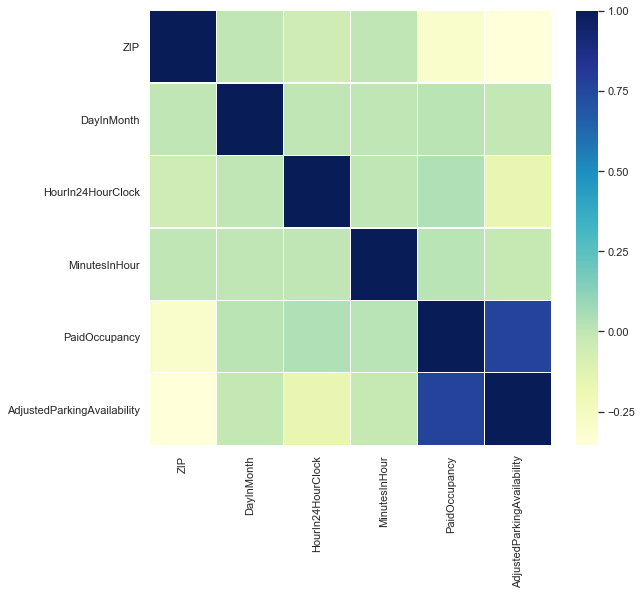

In [26]:
# correlation matrix for all variables
corrmat = data_2018_ZIP.corr()   
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

From the above correlation matrix, we can see there is strong correlation between Parking Availability and Parking Occupancy. The Zip code is the least correlated with Parking availability.

### 2.1 STATSMODELS

In [6]:
# create a statsmodel
m_ZIP2 = ols('AdjustedParkingAvailability ~ C(ZIP)', data_2018_ZIP).fit()
print(m_ZIP2.summary())

                                 OLS Regression Results                                
Dep. Variable:     AdjustedParkingAvailability   R-squared:                       0.849
Model:                                     OLS   Adj. R-squared:                  0.849
Method:                          Least Squares   F-statistic:                 1.196e+05
Date:                         Fri, 27 Sep 2019   Prob (F-statistic):               0.00
Time:                                 10:08:49   Log-Likelihood:            -1.9482e+06
No. Observations:                       298080   AIC:                         3.896e+06
Df Residuals:                           298065   BIC:                         3.897e+06
Df Model:                                   14                                         
Covariance Type:                     nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

R_squared value tells us that 84,9% of the variance in the response variable (AdjustedParkingAvailability) can be explained by this linear regression model.

According to p-value for F-statistic, the overall regression is significant, i.e. the predictors are jointly informative. F-statistics is 119600 and Prob(F-statistics) is very small (less than 0.05). 
In the model there is 119600 times more explained variance than unexplaned variance.

ZIP code 98101 is the omitted group, so Intercept is the mean for this group. The coefficient for 98102 is -561.3939, which is the mean for zip code 98102 (83.32) minus the mean of the omitted zip code 98101 (644.71). We can validate coefficients for rest of zip codes, by same calculation and using following average values.

In [105]:
# compute average parking availability for each zip code
data_2018_ZIP.groupby('ZIP')['AdjustedParkingAvailability'].mean()

ZIP
98101     644.711861
98102      83.317989
98103      35.866409
98104    1141.554424
98105     414.633591
98107     235.300154
98109    1093.359053
98115      92.084208
98118      34.505453
98119      77.624846
98121     893.174743
98122     587.533377
98134      30.757654
98154       6.378086
98164       9.345267
Name: AdjustedParkingAvailability, dtype: float64

Based on these results, we can say that ZIP codes differ in their Parking availability, and that each ZIP code is significantly different from ZIP code 98101 (because each P>|t| with alpha = 0.05 is significant).

In [44]:
# create a model, by adding two additional features
m_ZIP3 = ols('AdjustedParkingAvailability ~ C(ZIP) + C(Weekday) + HourIn24HourClock', data_2018_ZIP).fit()
print(m_ZIP3.summary())

                                 OLS Regression Results                                
Dep. Variable:     AdjustedParkingAvailability   R-squared:                       0.884
Model:                                     OLS   Adj. R-squared:                  0.884
Method:                          Least Squares   F-statistic:                 1.140e+05
Date:                         Fri, 27 Sep 2019   Prob (F-statistic):               0.00
Time:                                 22:05:30   Log-Likelihood:            -1.9083e+06
No. Observations:                       298080   AIC:                         3.817e+06
Df Residuals:                           298059   BIC:                         3.817e+06
Df Model:                                   20                                         
Covariance Type:                     nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

These results indicate that the overall interaction is indeed significant. R_squared is for 0.035 greater than in previous model.

Like in above model, each coefficient represents the difference between the mean of that level of the category and the mean of the reference level of the same category. Reference level is Intercept and consist of Zip code 98101 and Friday as day of the week. The coefficient for HourIn24HourClock indicates that on average for every hour increase in HourIn24HourClock the Parking availability is predicted to decrease by 22.47 parking spots. Since each coefficient has P>|t| (with alpha=0.05) less than zero, we can say they are significant.

In summary, these results indicate that the Parking availability are significantly different for the ZIP codes and days of the week and hour of the day. Zip codes that have negative coefficient have significantly higher Parking availability than Zip code 98101. And all days of the week have lower average Parking availability compare to Friday.

This model with three features has an F-statistic of 114000 and AIC of 3817000. The previous model with only ZIP feature has an F-statistic of 119600 and the AIC of 3896000. Based on both AIC values, this means that the model with three features provides a better fit to the data than the model that only includes one categorical feature.

In [45]:
# getting fitted values
m_ZIP3_fitted = m_ZIP3.fittedvalues.copy()

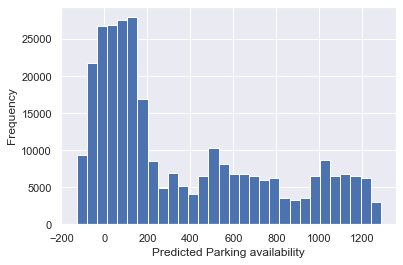

In [46]:
# frequency of predicted values
plt.hist(m_ZIP3_fitted, bins=30)
plt.xlabel("Predicted Parking availability")
plt.ylabel("Frequency")
plt.show()

From the graph we can see that the model often predicted availability less than 200 parking spots.

Now we can graph the observed values and the predicted values.

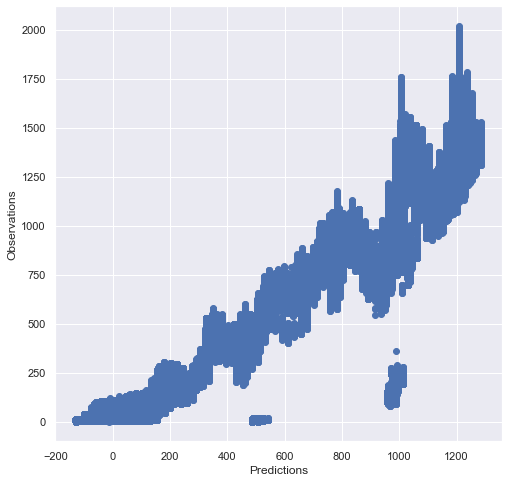

In [47]:
# plotting original vs. predicted values
fig, ax = plt.subplots(figsize=(8,8))
_ = ax.scatter(m_ZIP3_fitted, data_2018_ZIP.AdjustedParkingAvailability)
_ = plt.xlabel('Predictions')
_ = plt.ylabel('Observations')
plt.show()

From the above graph we can see that the model had a challenge predicting right values. For example it often predicted 1000 available parking spots, when the actual value was somewhere between 100 and 1800. Or it predicted 1200 available parking spots, but the actual values had a range of 1000 to 2100. From a practical perspective, it is not good that it predicted 500 available parking spots, when there were none. It would mean that it mislead drivers looking for parking spots.  

In [48]:
# calculate prediction errors
m_ZIP3_residuals = data_2018_ZIP.AdjustedParkingAvailability - m_ZIP3_fitted

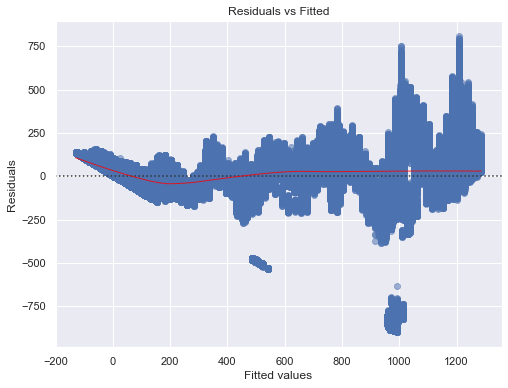

In [50]:
# create residual plot
plt.figure(figsize=(8,6))
_ = sns.residplot(m_ZIP3_fitted, data_2018_ZIP.AdjustedParkingAvailability, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
_ = plt.title('Residuals vs Fitted')
_ = plt.xlabel('Fitted values')
_ = plt.ylabel('Residuals')
plt.show()

We can see that the majority of residuals fall between -300 and 300. The points, where the values of residuals are greater than 500 or less than -500, might be outliers. 

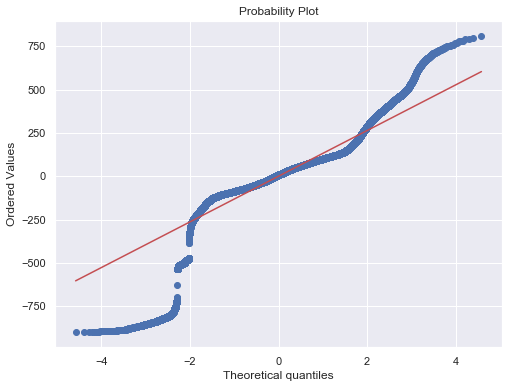

In [49]:
# construct a quantile plot of the residuals
fig, ax = plt.subplots(figsize=(8,6))
_, (__, ___, r) = stats.probplot(m_ZIP3_residuals, plot=ax, fit=True)
plt.show()

This plot should show if the residuals are normally distributed. A good normal QQ plot has all of the residuals lying on or close to the red line. Looking at the graph above, there are many points that fall far from the red line. This is indicative of the residuals not being normally distributed. We can also see these points in the above scatter plot, where the value of residuals is greater than 250 or lower than -250. These points might be outliers.

Let's check how a model for specific zip code would look like, for a zip code with a lot of available paid parking spots:

### 2.2 ZIP 98101

In [79]:
# group dataframe by zip code and count number of rows for parking availability
data_2018_ZIP.groupby('ZIP')['AdjustedParkingAvailability'].count()

ZIP
98101    22680
98102    22680
98103    19440
98104    19440
98105    19440
98107    19440
98109    19440
98115    19440
98118    19440
98119    19440
98121    19440
98122    22680
98134    16200
98154    19440
98164    19440
Name: AdjustedParkingAvailability, dtype: int64

In [82]:
# extract data fro zip code 98101
data_ZIP_98101 = data_2018_ZIP[data_2018_ZIP['ZIP'] == 98101]

In [83]:
# check the first few rows
data_ZIP_98101.head()

,ZIP,OccupancyDateTime,Weekday,Date,DayInMonth,HourIn24HourClock,MinutesInHour,PaidOccupancy,AdjustedParkingAvailability
0,98101,03/21/2018 01:00:00 PM,Wednesday,03/21/2018,21,13,0,523,783
1,98101,03/21/2018 01:01:00 PM,Wednesday,03/21/2018,21,13,1,526,781
2,98101,03/21/2018 01:02:00 PM,Wednesday,03/21/2018,21,13,2,522,784
3,98101,03/21/2018 01:03:00 PM,Wednesday,03/21/2018,21,13,3,517,792
4,98101,03/21/2018 01:04:00 PM,Wednesday,03/21/2018,21,13,4,520,790


In [86]:
# create a statsmodel for the zip code 98101 data
m_ZIP_98101 = ols('AdjustedParkingAvailability ~ C(Weekday) + HourIn24HourClock', data_ZIP_98101).fit()
print(m_ZIP_98101.summary())

                                 OLS Regression Results                                
Dep. Variable:     AdjustedParkingAvailability   R-squared:                       0.664
Model:                                     OLS   Adj. R-squared:                  0.664
Method:                          Least Squares   F-statistic:                     7471.
Date:                         Sat, 28 Sep 2019   Prob (F-statistic):               0.00
Time:                                 14:56:26   Log-Likelihood:            -1.4763e+05
No. Observations:                        22680   AIC:                         2.953e+05
Df Residuals:                            22673   BIC:                         2.953e+05
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

ANSWER:


In [87]:
# getting fitted values
m_ZIP_98101_fitted = m_ZIP_98101.fittedvalues.copy()

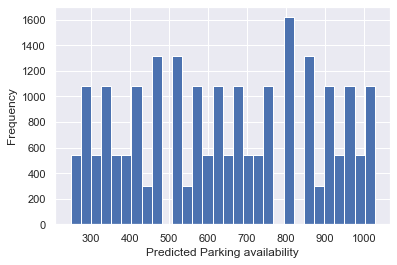

In [88]:
# frequency of predicted values
plt.hist(m_ZIP_98101_fitted, bins=30)
plt.xlabel("Predicted Parking availability")
plt.ylabel("Frequency")
plt.show()

From the plot above, we can see that model often predicted parking availability at around 550 parking spots or at 1100 parking spots.

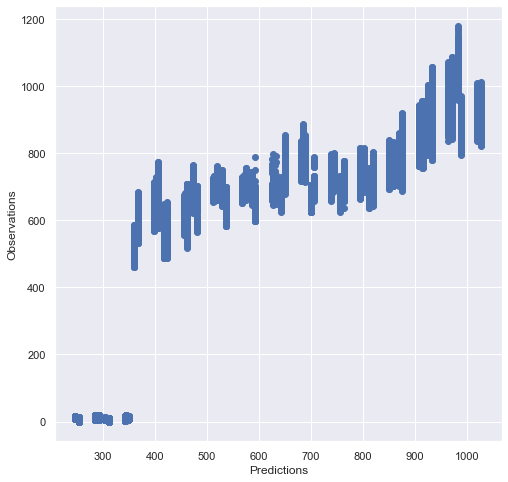

In [89]:
# plotting original vs. predicted values
fig, ax = plt.subplots(figsize=(8,8))
_ = ax.scatter(m_ZIP_98101_fitted, data_ZIP_98101.AdjustedParkingAvailability)
_ = plt.xlabel('Predictions')
_ = plt.ylabel('Observations')
plt.show()

Looking at the graph above we can see that the model has many prediction errors. For example when the true value was 10 parking spots it predicted 300 parking spots. Or when the true value was 600 parking spots available, it predicted 400 parking spots. 

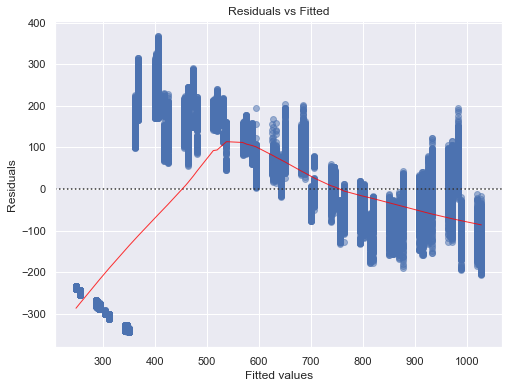

In [90]:
# create residual plot
plt.figure(figsize=(8,6))
_ = sns.residplot(m_ZIP_98101_fitted, data_ZIP_98101.AdjustedParkingAvailability, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
_ = plt.title('Residuals vs Fitted')
_ = plt.xlabel('Fitted values')
_ = plt.ylabel('Residuals')
plt.show()

The plot shows that the when true value is less than 350, the prediction errors is negative, which means it predicted between 220 and 350 more parking spots available than there actually would be. But when the true value is between 350 and 700, with most often positive prediction errors, which means it predicted fewer parking spots available than there actually would be. For values greater than 700, prediction errors are generally negative. The model predicted between 0 and 200 more parking spots available than there were in reality. Overall most prediction errors are in range between -200 and 200 parking spots.

In [96]:
# calculate prediction errors
m_ZIP_98101_residuals = data_ZIP_98101.AdjustedParkingAvailability - m_ZIP_98101_fitted

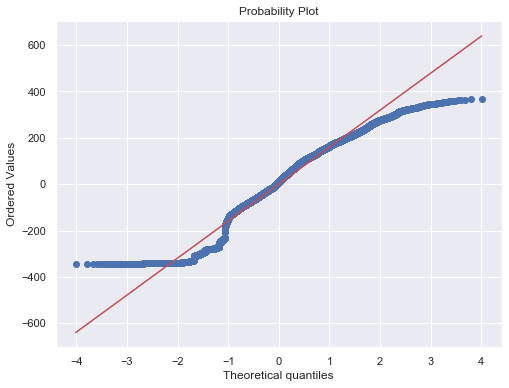

In [97]:
fig, ax = plt.subplots(figsize=(8,6))
_, (__, ___, r) = stats.probplot(m_ZIP_98101_residuals, plot=ax, fit=True)
plt.show()

By looking at this plot we can say that prediction errors aren't normally distributed.

Let's see if we get similar results for another Zip code.

### 2.3 ZIP 98121

In [48]:
# selecting rows from the dataframe for zip code 98121
data_ZIP_98121 = data_2018_ZIP[data_2018_ZIP['ZIP'] == 98121]

In [49]:
# create a statsmodel
m_ZIP_98121 = ols('AdjustedParkingAvailability ~ C(Weekday) + HourIn24HourClock', data_ZIP_98121).fit()
print(m_ZIP_98121.summary())

                                 OLS Regression Results                                
Dep. Variable:     AdjustedParkingAvailability   R-squared:                       0.225
Model:                                     OLS   Adj. R-squared:                  0.225
Method:                          Least Squares   F-statistic:                     941.7
Date:                         Sun, 29 Sep 2019   Prob (F-statistic):               0.00
Time:                                 10:08:56   Log-Likelihood:            -1.2794e+05
No. Observations:                        19440   AIC:                         2.559e+05
Df Residuals:                            19433   BIC:                         2.560e+05
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

ANSWER:



In [50]:
# getting fitted values
m_ZIP_98121_fitted = m_ZIP_98121.fittedvalues.copy()

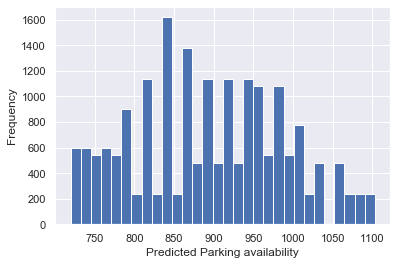

In [51]:
# frequency of predicted values
plt.hist(m_ZIP_98121_fitted, bins=30)
plt.xlabel("Predicted Parking availability")
plt.ylabel("Frequency")
plt.show()

The graph above, tell us that the model often predicted parking availability with less than 600 parking spots.

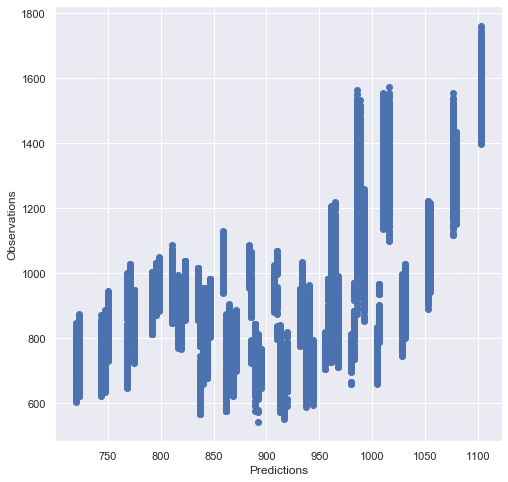

In [52]:
# plotting original vs. predicted values
fig, ax = plt.subplots(figsize=(8,8))
_ = ax.scatter(m_ZIP_98121_fitted, data_ZIP_98121.AdjustedParkingAvailability)
_ = plt.xlabel('Predictions')
_ = plt.ylabel('Observations')
plt.show()

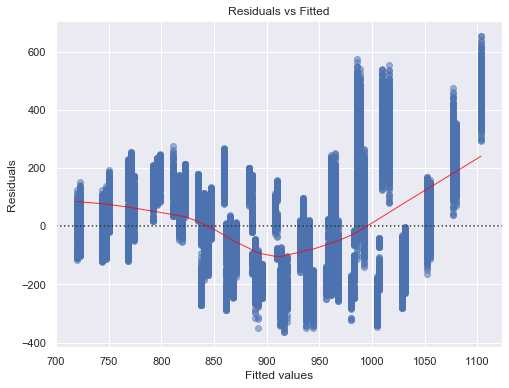

In [53]:
# create residual plot
plt.figure(figsize=(8,6))
_ = sns.residplot(m_ZIP_98121_fitted, data_ZIP_98121.AdjustedParkingAvailability, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
_ = plt.title('Residuals vs Fitted')
_ = plt.xlabel('Fitted values')
_ = plt.ylabel('Residuals')
plt.show()

ANSWER:

In [54]:
# calculate prediction errors
m_ZIP_98121_residuals = data_ZIP_98121.AdjustedParkingAvailability - m_ZIP_98121_fitted

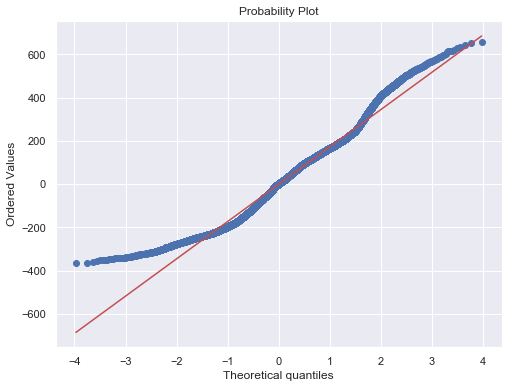

In [55]:
fig, ax = plt.subplots(figsize=(8,6))
_, (__, ___, r) = stats.probplot(m_ZIP_98121_residuals, plot=ax, fit=True)
plt.show()

In [ ]:
ANSWER:

Now, lets see a model for ZIP code with fewer available paid parking spots.

### 2.4 ZIP 98115

In [20]:
# create a dataframe for zip code 98115
data_ZIP_98115 = data_2018_ZIP[data_2018_ZIP['ZIP'] == 98115]

In [21]:
# create a statsmodel
m_ZIP_98115 = ols('AdjustedParkingAvailability ~ C(Weekday) + HourIn24HourClock', data_ZIP_98115).fit()
print(m_ZIP_98115.summary())

                                 OLS Regression Results                                
Dep. Variable:     AdjustedParkingAvailability   R-squared:                       0.492
Model:                                     OLS   Adj. R-squared:                  0.492
Method:                          Least Squares   F-statistic:                     3140.
Date:                         Sun, 29 Sep 2019   Prob (F-statistic):               0.00
Time:                                 09:36:18   Log-Likelihood:                -88507.
No. Observations:                        19440   AIC:                         1.770e+05
Df Residuals:                            19433   BIC:                         1.771e+05
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

ANSWER:

In [22]:
# getting fitted values
m_ZIP_98115_fitted = m_ZIP_98115.fittedvalues.copy()

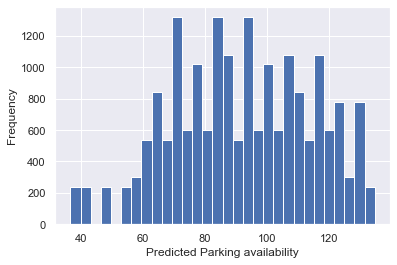

In [23]:
# frequency of predicted values
plt.hist(m_ZIP_98115_fitted, bins=30)
plt.xlabel("Predicted Parking availability")
plt.ylabel("Frequency")
plt.show()

ANSWER:

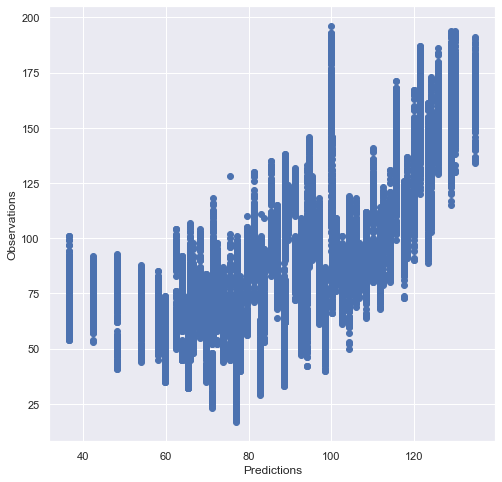

In [24]:
# plotting original vs. predicted values
fig, ax = plt.subplots(figsize=(8,8))
_ = ax.scatter(m_ZIP_98115_fitted, data_ZIP_98115.AdjustedParkingAvailability)
_ = plt.xlabel('Predictions')
_ = plt.ylabel('Observations')
plt.show()

ANSWER:

In [25]:
# calculate prediction errors
m_ZIP_98115_residuals = data_ZIP_98115.AdjustedParkingAvailability - m_ZIP_98115_fitted

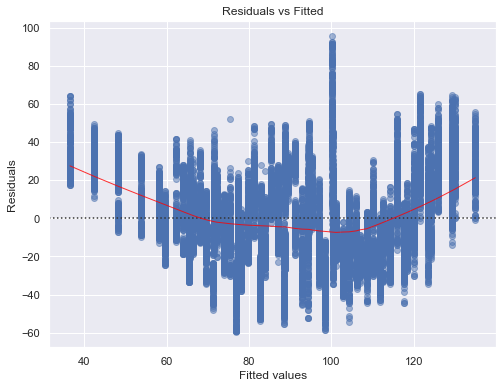

In [26]:
# create residual plot
plt.figure(figsize=(8,6))
_ = sns.residplot(m_ZIP_98115_fitted, data_ZIP_98115.AdjustedParkingAvailability, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
_ = plt.title('Residuals vs Fitted')
_ = plt.xlabel('Fitted values')
_ = plt.ylabel('Residuals')
plt.show()

ANSWER:

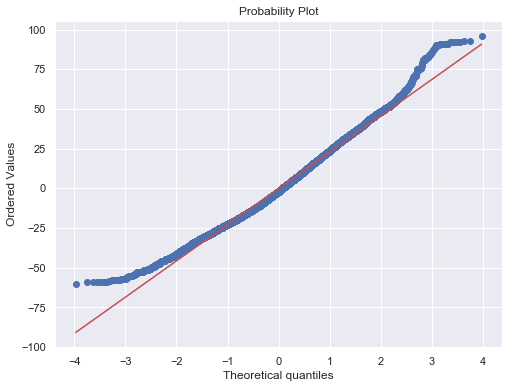

In [27]:
# ploting residuals for normality
fig, ax = plt.subplots(figsize=(8,6))
_, (__, ___, r) = stats.probplot(m_ZIP_98115_residuals, plot=ax, fit=True)
plt.show()

ANSWER:

### 2.5 Building a more complex model

In [28]:
# create a model
m_ZIP5 = ols('AdjustedParkingAvailability ~ C(ZIP) * C(Weekday) + HourIn24HourClock', data_2018_ZIP).fit()
print(m_ZIP5.summary())

                                 OLS Regression Results                                
Dep. Variable:     AdjustedParkingAvailability   R-squared:                       0.886
Model:                                     OLS   Adj. R-squared:                  0.886
Method:                          Least Squares   F-statistic:                 2.580e+04
Date:                         Sun, 29 Sep 2019   Prob (F-statistic):               0.00
Time:                                 09:43:39   Log-Likelihood:            -1.9058e+06
No. Observations:                       298080   AIC:                         3.812e+06
Df Residuals:                           297989   BIC:                         3.813e+06
Df Model:                                   90                                         
Covariance Type:                     nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------

ANSWER:

## 3 PARKING AREA

In [11]:
# get the first 5 rows
data_2018_PARK.head()

,PaidParkingArea,OccupancyDateTime,Weekday,Date,DayInMonth,HourIn24HourClock,MinutesInHour,ZIP,PaidOccupancy,AdjustedParkingAvailability
0,12th Avenue,03/21/2018 01:00:00 PM,Wednesday,03/21/2018,21,13,0,98122,52,24
1,12th Avenue,03/21/2018 01:01:00 PM,Wednesday,03/21/2018,21,13,1,98122,50,26
2,12th Avenue,03/21/2018 01:02:00 PM,Wednesday,03/21/2018,21,13,2,98122,51,25
3,12th Avenue,03/21/2018 01:03:00 PM,Wednesday,03/21/2018,21,13,3,98122,53,23
4,12th Avenue,03/21/2018 01:04:00 PM,Wednesday,03/21/2018,21,13,4,98122,53,23


In [12]:
# check additional information
data_2018_PARK.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633422 entries, 0 to 633421
Data columns (total 10 columns):
PaidParkingArea                633422 non-null object
OccupancyDateTime              633422 non-null object
Weekday                        633422 non-null object
Date                           633422 non-null object
DayInMonth                     633422 non-null int64
HourIn24HourClock              633422 non-null int64
MinutesInHour                  633422 non-null int64
ZIP                            633422 non-null int64
PaidOccupancy                  633422 non-null int64
AdjustedParkingAvailability    633422 non-null int64
dtypes: int64(6), object(4)
memory usage: 48.3+ MB


In [42]:
# get all names of parking areas
data_2018_PARK.PaidParkingArea.unique()

array(['12th Avenue', 'Ballard', 'Ballard Locks', 'Belltown',
       'Capitol Hill', 'Cherry Hill', 'Chinatown/ID', 'Columbia City',
       'Commercial Core', 'Denny Triangle', 'First Hill', 'Fremont',
       'Green Lake', 'Pike-Pine', 'Pioneer Square', 'Roosevelt',
       'South Lake Union', 'University District', 'Uptown',
       'Uptown Triangle'], dtype=object)

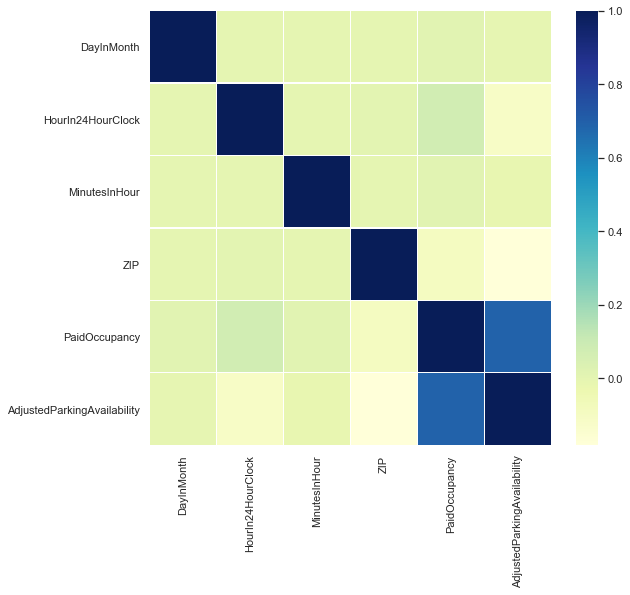

In [41]:
# correlation matrix for all variables
corrmat = data_2018_PARK.corr()   
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

From the correlation matrix, we can see that there is almost none correlation between these variables. There is only one strong correlation, which is between Paid parking Occupancy and Parking availability.

Let's take a look at the model between these two variables.


### 3.1 MODEL WITH JUST PAID PARKING OCCUPANCY AS INDEPENDENT VARIABLE

In [71]:
# create a statsmodel
m_PARK11 = ols('AdjustedParkingAvailability ~ PaidOccupancy', data_2018_PARK).fit()
print(m_PARK11.summary())

                                 OLS Regression Results                                
Dep. Variable:     AdjustedParkingAvailability   R-squared:                       0.481
Model:                                     OLS   Adj. R-squared:                  0.481
Method:                          Least Squares   F-statistic:                 5.880e+05
Date:                         Sat, 28 Sep 2019   Prob (F-statistic):               0.00
Time:                                 09:09:17   Log-Likelihood:            -4.1087e+06
No. Observations:                       633422   AIC:                         8.217e+06
Df Residuals:                           633420   BIC:                         8.217e+06
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [96]:
# ANSWER:

Since the above model didn't tell us much about parking availability in various parking areas, lets build a model with PaidParkingArea as a categorical independent variable.

### 3.2 MODEL WITH PAIDPARKINGAREA VARIABLE

In [77]:
# create a statsmodel
m_PARK1 = ols('AdjustedParkingAvailability ~ C(PaidParkingArea)', data_2018_PARK).fit()
print(m_PARK1.summary())

                                 OLS Regression Results                                
Dep. Variable:     AdjustedParkingAvailability   R-squared:                       0.295
Model:                                     OLS   Adj. R-squared:                  0.295
Method:                          Least Squares   F-statistic:                 1.395e+04
Date:                         Sun, 29 Sep 2019   Prob (F-statistic):               0.00
Time:                                 10:44:35   Log-Likelihood:            -4.2060e+06
No. Observations:                       633422   AIC:                         8.412e+06
Df Residuals:                           633402   BIC:                         8.412e+06
Df Model:                                   19                                         
Covariance Type:                     nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------

12th Avenue parking area is the omitted group, so Intercept is the mean for 12th Avenue. The coefficient for Ballard is the mean for Ballard minus the mean of the omitted group (12th Avenue). Columbia City has the lowest coefficient (-2.9065), 34.5 is the mean of this parking area minus the mean of the omitted group. One can verify this by comparing the coefficients with the means of the groups.

Coefficient is the amount you need to add (to intercept - 12th Avenue) to get the mean for the group (Ballard).
The value of the Intercept is the unweighted average of the means of the groups.

Examples of calculating the means of groups:

12th Avenue = 37.42

Ballard = 150.48 + 37.42 = 187.9

Columbia City = -2.91 + 37.42 = 34.51

South Lake Union = 481.94 + 37.42 = 519.36

Based on these results, we can say that Parking areas differ in their Parking availability, some have more, some have less. In particular Columbia City, Fremont and Green Lake are not significantly different from 12th Avenue (because p-value (alpha = 0.05) for each one is not significant). South Lake Union, which has the greatest coefficient, is significantly different from 12th Avenue (because p-value (alpha = 0.05) for South Lake Union is significant).

In [78]:
# getting fitted values
m_PARK1_fitted = m_PARK1.fittedvalues.copy()

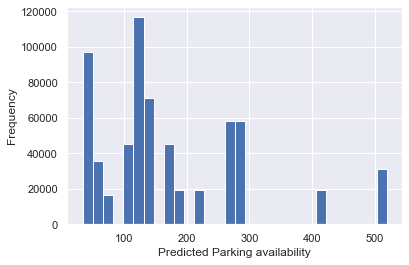

In [79]:
# frequency of predicted values
plt.hist(m_PARK1_fitted, bins=30)
plt.xlabel("Predicted Parking availability")
plt.ylabel("Frequency")
plt.show()

From the plot above, we can see that the higest frequency of predicted values sits around 120 and it is almost 120000 times. The greates predicted value was a bit more than 500 parking spots. Overall the most frequent predicted values are below 300 parking spots.

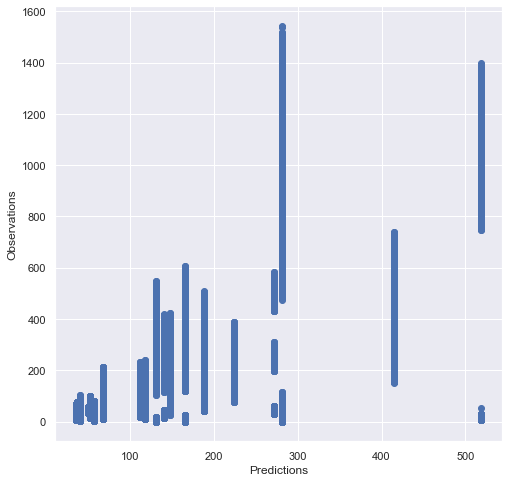

In [80]:
# plotting original vs. predicted values
fig, ax = plt.subplots(figsize=(8,8))
_ = ax.scatter(m_PARK1_fitted, data_2018_PARK.AdjustedParkingAvailability)
_ = plt.xlabel('Predictions')
_ = plt.ylabel('Observations')
plt.show()

From the plot we can say that this model is not good at predicting parking availability, expecially not values that are greater than 200. 

In [82]:
# calculate prediction errors
m_PARK1_residuals = data_2018_PARK.AdjustedParkingAvailability - m_PARK1_fitted

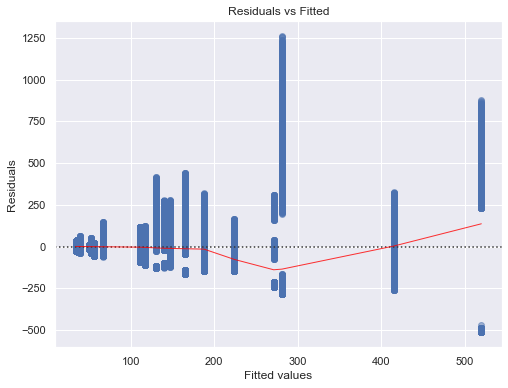

In [83]:
# create residual plot
plt.figure(figsize=(8,6))
_ = sns.residplot(m_PARK1_fitted, data_2018_PARK.AdjustedParkingAvailability, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
_ = plt.title('Residuals vs Fitted')
_ = plt.xlabel('Fitted values')
_ = plt.ylabel('Residuals')
plt.show()

This plot supports what we have already assumed in the previous one, that the model is not good at predicting values greater than 200. We can see that prediction errors are much higher than for smaller values. Most of the prediction errors are between -250 and 500.

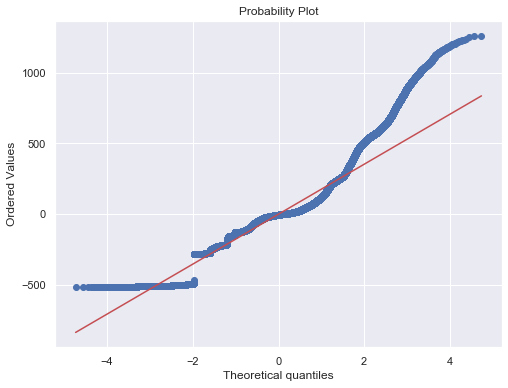

In [84]:
# plot residuals for normality
fig, ax = plt.subplots(figsize=(8,6))
_, (__, ___, r) = stats.probplot(m_PARK1_residuals, plot=ax, fit=True)
plt.show()

The above plot tells us that prediction errors aren't normally distributed, since prediction errors aren't gathered around the red line.

Now, let's build a model to include time units (day of the week and hour of the day), to see if it performs better:

### 3.3 MODEL WITH 3 INDEPENDENT VARIABLES

In [32]:
# create a statsmodel
m_PARK3 = ols('AdjustedParkingAvailability ~ C(PaidParkingArea) + C(Weekday) + HourIn24HourClock', data_2018_PARK).fit()
print(m_PARK3.summary())

                                 OLS Regression Results                                
Dep. Variable:     AdjustedParkingAvailability   R-squared:                       0.304
Model:                                     OLS   Adj. R-squared:                  0.304
Method:                          Least Squares   F-statistic:                 1.109e+04
Date:                         Sun, 29 Sep 2019   Prob (F-statistic):               0.00
Time:                                 09:51:17   Log-Likelihood:            -4.2017e+06
No. Observations:                       633422   AIC:                         8.403e+06
Df Residuals:                           633396   BIC:                         8.404e+06
Df Model:                                   25                                         
Covariance Type:                     nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------

12th Avenue parking area and Friday as a day of the week are the omitted groups (Intercept). 
Regression coefficient for Ballard means, 150.4808 is the difference between the mean of the Ballards parking area and the mean of all other parking areas, which in this model is represented by the 12th Avenue parking area. 
South Lake Union has the greatest regression coefficient. We can interpret that as, on average there being 475.9893 more parking spots available than in the 12th Avenue parking area.
All parking areas that have a negative coefficient, have on average less parking spots available than the 12th Avenue parking area.
By looking at coefficients for days of the week, they all had more parking spots available than Fridays.
These results indicate that the differences between Weekdays is significant, and the differences among the Parking areas are significant too, except three parking areas (Columbia City, Fremont and Green Lake).
The coefficient for HourIn24HourClock indicates that on average for every hour increase in HourIn24HourClock the Parking availability is predicted to decrease by 6.0445 parking spots. 
Overall, with F-statistic of 11090 and p-value 0.00 (with alpha=0.05), the model is significant.

This model with two additional features (Weekday and HourIn24HourClock) has an F-statistic of 11090 and AIC of 8403000. The previous model with only PaidparkingArea feature has an F-statistic of 13950 and the AIC of 8412000. Based on both AIC values, this means that the model with three features provides a better fit to the data than the model that only includes one categorical feature (PaidParkingArea).

In [33]:
# getting fitted values
m_PARK3_fitted = m_PARK3.fittedvalues.copy()

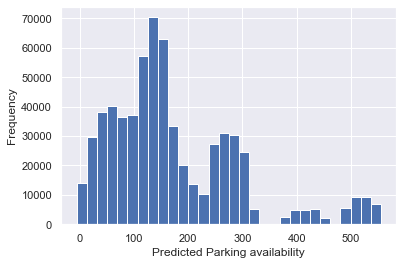

In [34]:
# frequency of predicted values
plt.hist(m_PARK3_fitted, bins=30)
plt.xlabel("Predicted Parking availability")
plt.ylabel("Frequency")
plt.show()

From the graph, we can see that the most frequent predicted parking availablity had value less than 200 parking spots. There were no predicted values greater than 600 parking spots.

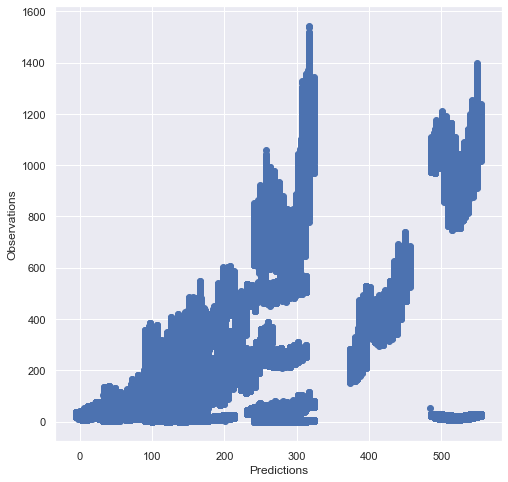

In [35]:
# plotting original vs. predicted values
fig, ax = plt.subplots(figsize=(8,8))
_ = ax.scatter(m_PARK3_fitted, data_2018_PARK.AdjustedParkingAvailability)
_ = plt.xlabel('Predictions')
_ = plt.ylabel('Observations')
plt.show()

The first thing to notice in the above plot is that the model never made prediction greater than 600, even though there are true values up to 1600. From that we can assume that this model is not good at predictions. We can see that the model never predicted the true value of 600 parking spots correctly. It also wrongly predicted occasions when there was no parking available, it predicted 500 available parking spots. 

In [99]:
# calculate prediction errors
m_PARK3_residuals = data_2018_PARK.AdjustedParkingAvailability - m_PARK3_fitted

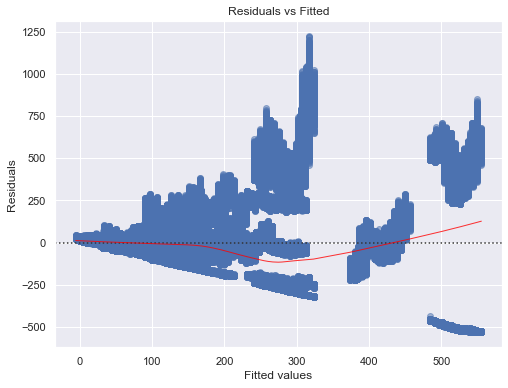

In [98]:
# create residual plot
plt.figure(figsize=(8,6))
_ = sns.residplot(m_PARK3_fitted, data_2018_PARK.AdjustedParkingAvailability, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
_ = plt.title('Residuals vs Fitted')
_ = plt.xlabel('Fitted values')
_ = plt.ylabel('Residuals')
plt.show()

From the residuals plot, we can see that the model made prediction errors in range from -510 all the way to 1250. Most values are between -270 and 500. There are more positive prediction errors than negative, which means it predicted lower numbers of available parking than there really was. 

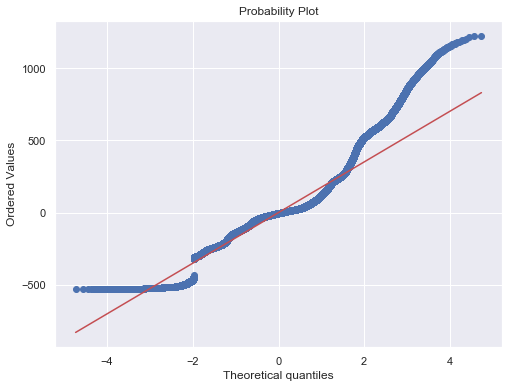

In [37]:
# plotting residuals for normality
fig, ax = plt.subplots(figsize=(8,6))
_, (__, ___, r) = stats.probplot(m_PARK3_residuals, plot=ax, fit=True)
plt.show()

This plot confirms that residuals don't have normal distribution, since there are many values that aren't close to red line. 

Let's take a look at two models, each for a specific parking area. We chose South Lake Union and Belltown, because they have high coefficients in the above model.

### 3.4 PARKING AREA South Lake Union

In [38]:
# create a dataframe for South Lake Union data
data_PARK_SLU = data_2018_PARK[data_2018_PARK['PaidParkingArea'] == 'South Lake Union']

In [39]:
# create a statsmodel
m_PARK_SLU = ols('AdjustedParkingAvailability ~ C(Weekday) + HourIn24HourClock', data_PARK_SLU).fit()
print(m_PARK_SLU.summary())

                                 OLS Regression Results                                
Dep. Variable:     AdjustedParkingAvailability   R-squared:                       0.024
Model:                                     OLS   Adj. R-squared:                  0.023
Method:                          Least Squares   F-statistic:                     125.6
Date:                         Sun, 29 Sep 2019   Prob (F-statistic):          1.26e-157
Time:                                 09:56:23   Log-Likelihood:            -2.3713e+05
No. Observations:                        31201   AIC:                         4.743e+05
Df Residuals:                            31194   BIC:                         4.743e+05
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

ANSWER:
Overall the model with F-statistic of 125.6 and p-value of 1.26e-157 is significant. 
Based on the P>|t| values, we can say that Tuesday, Wednesday and Thursday aren't significant, all other coefficients are.
HourIn24HourClock coefficient tells us, on average each additional hour is associated with an increase of 3.75 parking spots of the other variables.

In [56]:
# getting fitted values
m_PARK_SLU_fitted = m_PARK_SLU.fittedvalues.copy()

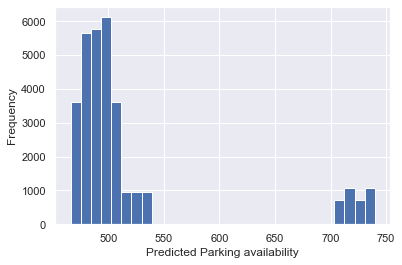

In [57]:
# frequency of predicted values
plt.hist(m_PARK_SLU_fitted, bins=30)
plt.xlabel("Predicted Parking availability")
plt.ylabel("Frequency")
plt.show()

Looking at the plot, we can see that most predicted values are less than 550 parking spots. In this model there are not many predicted values between 700 and 750 parking spots.

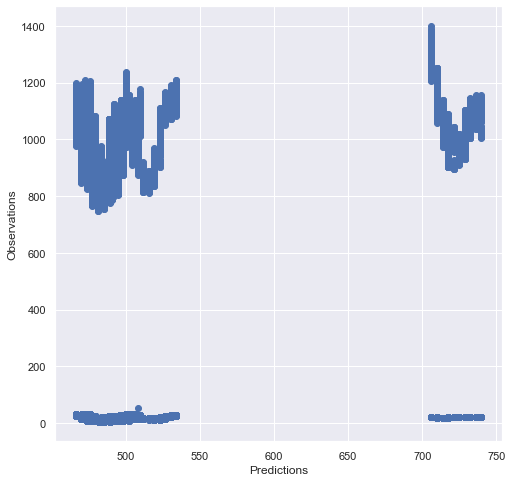

In [58]:
# plotting original vs. predicted values
fig, ax = plt.subplots(figsize=(8,8))
_ = ax.scatter(m_PARK_SLU_fitted, data_PARK_SLU.AdjustedParkingAvailability)
_ = plt.xlabel('Predictions')
_ = plt.ylabel('Observations')
plt.show()

The above plot shows that this model is not good at making predictions, since true values are in range of 0 to 1300 and predictions in range of 100 and 740. For example, when true value of parking availability was less than 100 parking spots it predicted 500 or more. We can see there are many true values greater than 800 parking spots, but the model didn't predict correctly any data point. 

In [59]:
# calculate prediction errors
m_PARK_SLU_residuals = data_PARK_SLU.AdjustedParkingAvailability - m_PARK_SLU_fitted

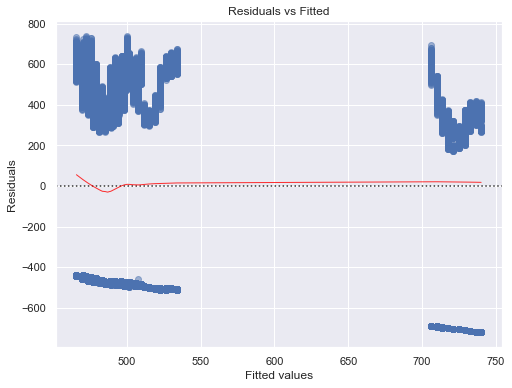

In [60]:
# create residual plot
plt.figure(figsize=(8,6))
_ = sns.residplot(m_PARK_SLU_fitted, data_PARK_SLU.AdjustedParkingAvailability, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
_ = plt.title('Residuals vs Fitted')
_ = plt.xlabel('Fitted values')
_ = plt.ylabel('Residuals')
plt.show()

In [ ]:
ANSWER:
    

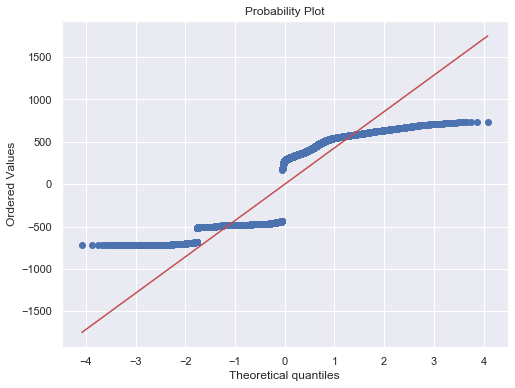

In [61]:
# ploting residuals for normality
fig, ax = plt.subplots(figsize=(8,6))
_, (__, ___, r) = stats.probplot(m_PARK_SLU_residuals, plot=ax, fit=True)
plt.show()

In [ ]:
ANSWER:

### 3.5 PARKING AREA Belltown

In [44]:
# create a dataframe for Belltown parking area
data_PARK_BELL = data_2018_PARK[data_2018_PARK['PaidParkingArea'] == 'Belltown']

In [45]:
# create a statsmodel
m_PARK_BELL = ols('AdjustedParkingAvailability ~ C(Weekday) + HourIn24HourClock', data_PARK_BELL).fit()
print(m_PARK_BELL.summary())

                                 OLS Regression Results                                
Dep. Variable:     AdjustedParkingAvailability   R-squared:                       0.006
Model:                                     OLS   Adj. R-squared:                  0.006
Method:                          Least Squares   F-statistic:                     58.01
Date:                         Sun, 29 Sep 2019   Prob (F-statistic):           6.68e-72
Time:                                 10:03:37   Log-Likelihood:            -4.2472e+05
No. Observations:                        57900   AIC:                         8.495e+05
Df Residuals:                            57893   BIC:                         8.495e+05
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [ ]:
# ANSWER:

In [68]:
# getting fitted values
m_PARK_BELL_fitted = m_PARK_BELL.fittedvalues.copy()

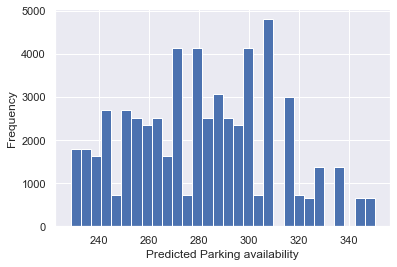

In [69]:
# frequency of predicted values
plt.hist(m_PARK_BELL_fitted, bins=30)
plt.xlabel("Predicted Parking availability")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# ANSWER:

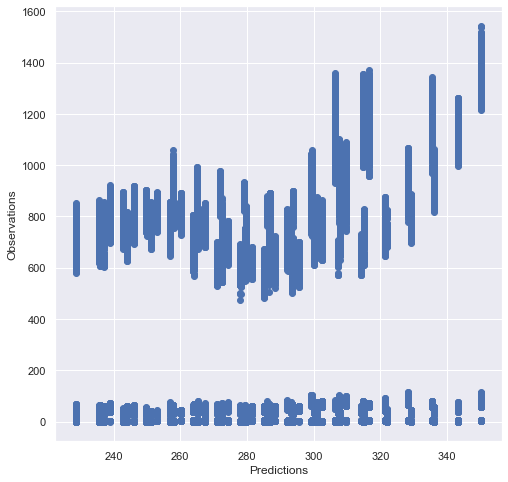

In [70]:
# plotting original vs. predicted values
fig, ax = plt.subplots(figsize=(8,8))
_ = ax.scatter(m_PARK_BELL_fitted, data_PARK_BELL.AdjustedParkingAvailability)
_ = plt.xlabel('Predictions')
_ = plt.ylabel('Observations')
plt.show()

In [ ]:
# ANSWER:

In [71]:
# calculate prediction errors
m_PARK_BELL_residuals = data_PARK_BELL.AdjustedParkingAvailability - m_PARK_BELL_fitted

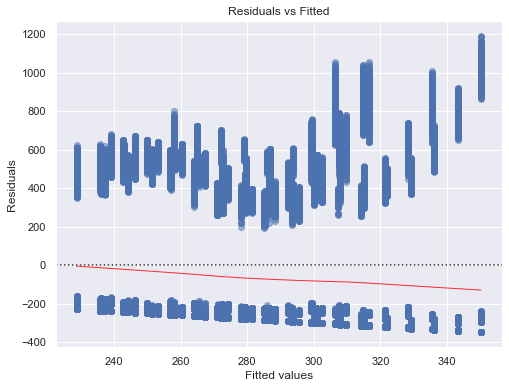

In [72]:
# create residual plot
plt.figure(figsize=(8,6))
_ = sns.residplot(m_PARK_BELL_fitted, data_PARK_BELL.AdjustedParkingAvailability, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
_ = plt.title('Residuals vs Fitted')
_ = plt.xlabel('Fitted values')
_ = plt.ylabel('Residuals')
plt.show()

In [ ]:
# ANSWER:

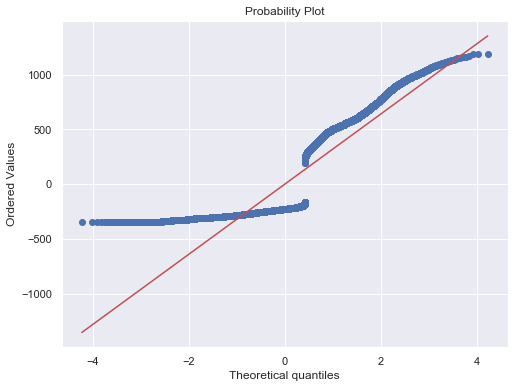

In [73]:
# ploting residuals for normality
fig, ax = plt.subplots(figsize=(8,6))
_, (__, ___, r) = stats.probplot(m_PARK_BELL_residuals, plot=ax, fit=True)
plt.show()

In [ ]:
# ANSWER:

Now, let's check the model for a parking area with the lowest coefficient:

### 3.6 PARK AREA Columbia City

In [40]:
# create a dataframe for Columbia City parking area
data_PARK_CC = data_2018_PARK[data_2018_PARK['PaidParkingArea'] == 'Columbia City']

In [41]:
# create a statsmodel
m_PARK_CC = ols('AdjustedParkingAvailability ~ C(Weekday) + HourIn24HourClock', data_PARK_CC).fit()
print(m_PARK_CC.summary())

                                 OLS Regression Results                                
Dep. Variable:     AdjustedParkingAvailability   R-squared:                       0.393
Model:                                     OLS   Adj. R-squared:                  0.393
Method:                          Least Squares   F-statistic:                     2096.
Date:                         Sun, 29 Sep 2019   Prob (F-statistic):               0.00
Time:                                 09:58:50   Log-Likelihood:                -69556.
No. Observations:                        19440   AIC:                         1.391e+05
Df Residuals:                            19433   BIC:                         1.392e+05
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

ANSWER:

In [62]:
# getting fitted values
m_PARK_CC_fitted = m_PARK_CC.fittedvalues.copy()

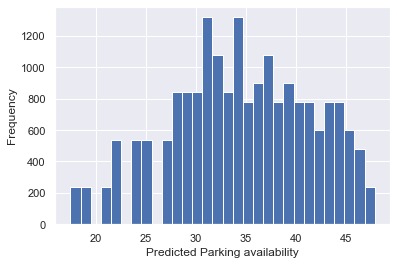

In [63]:
# frequency of predicted values
plt.hist(m_PARK_CC_fitted, bins=30)
plt.xlabel("Predicted Parking availability")
plt.ylabel("Frequency")
plt.show()

In [ ]:
ANSWER:

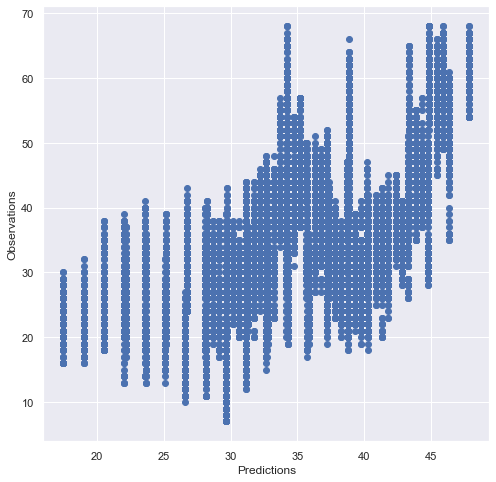

In [64]:
# plotting original vs. predicted values
fig, ax = plt.subplots(figsize=(8,8))
_ = ax.scatter(m_PARK_CC_fitted, data_PARK_CC.AdjustedParkingAvailability)
_ = plt.xlabel('Predictions')
_ = plt.ylabel('Observations')
plt.show()

In [ ]:
# ANSWER:

In [65]:
# calculate prediction errors
m_PARK_CC_residuals = data_PARK_CC.AdjustedParkingAvailability - m_PARK_CC_fitted

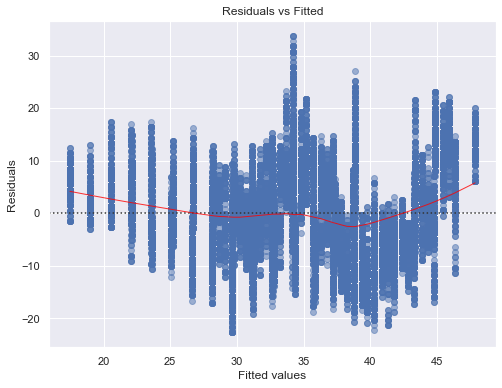

In [66]:
# create residual plot
plt.figure(figsize=(8,6))
_ = sns.residplot(m_PARK_CC_fitted, data_PARK_CC.AdjustedParkingAvailability, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
_ = plt.title('Residuals vs Fitted')
_ = plt.xlabel('Fitted values')
_ = plt.ylabel('Residuals')
plt.show()

In [ ]:
# ANSWER:

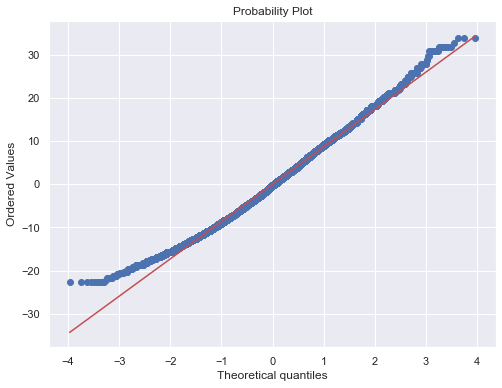

In [67]:
# ploting residuals for normality
fig, ax = plt.subplots(figsize=(8,6))
_, (__, ___, r) = stats.probplot(m_PARK_CC_residuals, plot=ax, fit=True)
plt.show()

In [ ]:
# ANSWER:

## 4 CONCLUSION